In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

cwd=os.getcwd()
main_directory = os.path.abspath(os.path.join(cwd, '..')) # main directory
print(main_directory)
sys.path.append(main_directory) # add parent directory to the system path

/Users/gbemidebe/Documents/GitHub/monsur/neuralnetwork


In [3]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from src.model import MLP, EarlyStopping, to_np
from src.plot import plot_scatter, plot_kde

In [4]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 200

In [5]:
# set random seed
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
random.seed(rand_seed)

In [6]:
data = pd.read_csv('../../data/cleaned_data.csv')
data.drop(columns=['S/N'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.00,14.05,118.7100,0.00,0.00,0.23,0.12,0.00,0.61
1,150,3.3,0.80,14.05,107.6772,0.20,0.00,0.23,0.07,0.00,0.66
2,150,3.2,0.50,14.05,91.1280,0.50,0.00,0.34,0.05,0.03,0.52
3,150,3.1,0.10,14.05,69.0624,0.90,0.01,0.42,0.05,0.02,0.42
4,150,3.0,0.05,14.05,66.3042,0.95,0.04,0.48,0.05,0.10,0.19


In [7]:
data.columns

Index(['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %', 'C2H4', 'CO', 'H2',
       'EtoH', 'FORM'],
      dtype='object')

In [8]:
# normalize the data to range [value/max, value/max]
feature_column = ['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %']
target_column = ['C2H4', 'EtoH', 'H2']
data[feature_column] = data[feature_column] / data[feature_column].max()
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,0.333333,0.744681,1.00,1.0,1.000000,0.00,0.00,0.23,0.12,0.00,0.61
1,0.333333,0.702128,0.80,1.0,0.907061,0.20,0.00,0.23,0.07,0.00,0.66
2,0.333333,0.680851,0.50,1.0,0.767652,0.50,0.00,0.34,0.05,0.03,0.52
3,0.333333,0.659574,0.10,1.0,0.581774,0.90,0.01,0.42,0.05,0.02,0.42
4,0.333333,0.638298,0.05,1.0,0.558539,0.95,0.04,0.48,0.05,0.10,0.19


In [9]:
num_points = data.shape[0]
X = torch.from_numpy(data[feature_column].values).float()
y = torch.from_numpy(data[target_column].values).float()
print(X.shape, y.shape)

torch.Size([35, 6]) torch.Size([35, 3])


In [10]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

In [11]:
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(np.array([6, 20, 20, 15, 3])).to(device)
es = EarlyStopping(tolerance=5, min_delta=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
loss_fn = nn.MSELoss(reduction ='mean')
steps = 10000
record_onn_loss = []
record_onn_loss_test = []
for epoch in range(steps):
  # zero gradients
  optimizer.zero_grad()
  # forward pass
  output = model(X_train)
  # calculate loss
  loss = loss_fn(output, y_train)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    record_onn_loss.append(loss.item())

  # early stopping
  avg_loss = np.mean(record_onn_loss)
  with torch.no_grad():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    if epoch % 100 == 0:
      record_onn_loss_test.append(test_loss.item())
      print(f'Epoch: {epoch}, Train Loss {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
    if es(loss.item(), test_loss.item()):
      print(f'Early stopping at step {epoch}')
      break


Epoch: 0, Train Loss 0.250, Test Loss: 0.215
Epoch: 100, Train Loss 0.013, Test Loss: 0.019
Epoch: 200, Train Loss 0.010, Test Loss: 0.019
Epoch: 300, Train Loss 0.010, Test Loss: 0.018
Epoch: 400, Train Loss 0.009, Test Loss: 0.017
Epoch: 500, Train Loss 0.009, Test Loss: 0.016
Epoch: 600, Train Loss 0.007, Test Loss: 0.014
Epoch: 700, Train Loss 0.007, Test Loss: 0.013
Epoch: 800, Train Loss 0.006, Test Loss: 0.012
Epoch: 900, Train Loss 0.005, Test Loss: 0.012
Epoch: 1000, Train Loss 0.005, Test Loss: 0.011
Epoch: 1100, Train Loss 0.004, Test Loss: 0.010
Epoch: 1200, Train Loss 0.004, Test Loss: 0.009
Epoch: 1300, Train Loss 0.004, Test Loss: 0.008
Epoch: 1400, Train Loss 0.004, Test Loss: 0.008
Epoch: 1500, Train Loss 0.003, Test Loss: 0.008
Epoch: 1600, Train Loss 0.003, Test Loss: 0.007
Epoch: 1700, Train Loss 0.003, Test Loss: 0.007
Epoch: 1800, Train Loss 0.003, Test Loss: 0.007
Epoch: 1900, Train Loss 0.003, Test Loss: 0.007
Epoch: 2000, Train Loss 0.003, Test Loss: 0.006
Epoc

In [12]:
steps

10000

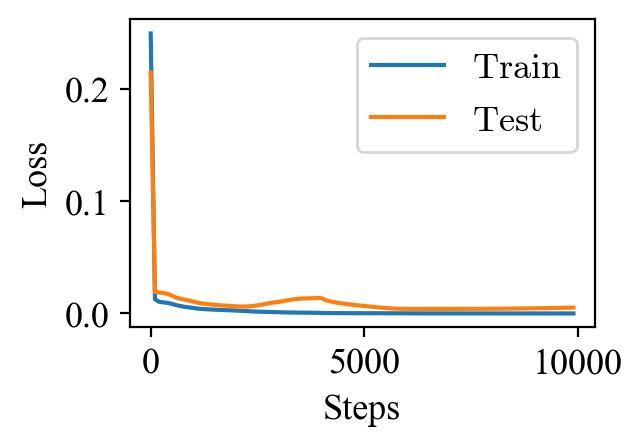

In [13]:
plt.figure(figsize=(3, 2))
epochs = np.arange(0, steps, 100)
plt.plot(epochs, record_onn_loss, label=r'$\rm Train $')
plt.plot(epochs, record_onn_loss_test, label=r'$\rm Test $')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.legend()

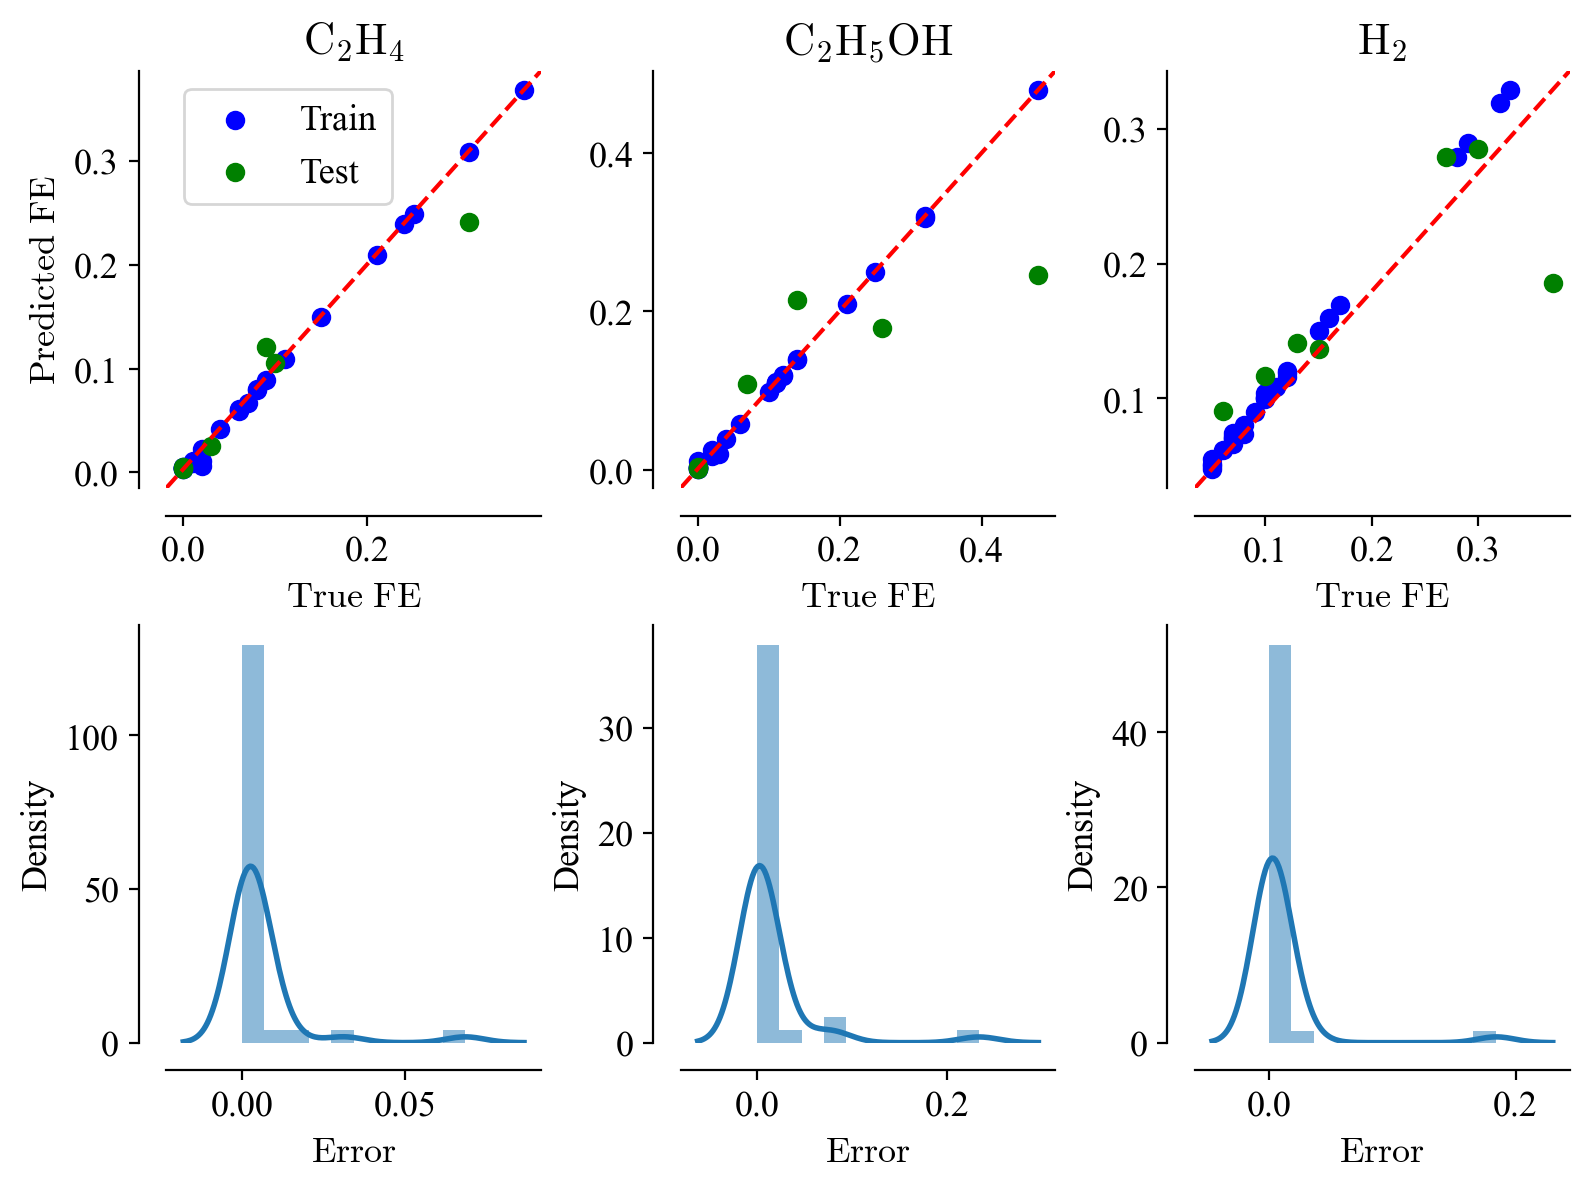

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
plot_target_column = [r'$\rm C_2H_4$', r'$\rm C_2H_5OH$', r'$\rm H_2$']
output_test = model(X_test) # predict the test data


df = {
        'y_train': y_train, 'y_test': y_test, 
        'output_train': output, 'output_test': output_test
        }
# Plot scatter plots
for col in range(3):
    plot_scatter(ax=ax, data=df, row=0, col=col, column_names=plot_target_column)

# Plot KDE plots
for col in range(3):
    plot_kde(ax=ax, data=df, row=1, col=col)

plt.tight_layout()
sns.despine(fig=fig, offset=10)
plt.show()


In [15]:
print(f"C2H4")
print(f"Train MSE: {mean_squared_error(output[:, 0].detach().numpy(), y_train.detach().numpy()[:, 0]):.3f}")
print(f"Test MSE: {mean_squared_error(output_test[:, 0].detach().numpy(), y_test.detach().numpy()[:, 0]):.3f}")
print(f"Train R2: {r2_score(output[:, 0].detach().numpy(), y_train.detach().numpy()[:, 0]):.3f}")
print(f"Test R2: {r2_score(output_test[:, 0].detach().numpy(), y_test.detach().numpy()[:, 0]):.3f}")
print(f"Train MAE: {mean_absolute_error(output[:, 0].detach().numpy(), y_train.detach().numpy()[:, 0]):.3f}")
print(f"Test MAE: {mean_absolute_error(output_test[:, 0].detach().numpy(), y_test.detach().numpy()[:, 0]):.3f}")

print(f"C2H5OH")
print(f"Train MSE: {mean_squared_error(output[:, 1].detach().numpy(), y_train.detach().numpy()[:, 1]):.3f}")
print(f"Test MSE: {mean_squared_error(output_test[:, 1].detach().numpy(), y_test.detach().numpy()[:, 1]):.3f}")
print(f"Train R2: {r2_score(output[:, 1].detach().numpy(), y_train.detach().numpy()[:, 1]):.3f}")
print(f"Test R2: {r2_score(output_test[:, 1].detach().numpy(), y_test.detach().numpy()[:, 1]):.3f}")
print(f"Train MAE: {mean_absolute_error(output[:, 1].detach().numpy(), y_train.detach().numpy()[:, 1]):.3f}")
print(f"Test MAE: {mean_absolute_error(output_test[:, 1].detach().numpy(), y_test.detach().numpy()[:, 1]):.3f}")

print(f"H2")
print(f"Train MSE: {mean_squared_error(output[:, 2].detach().numpy(), y_train.detach().numpy()[:, 2]):.3f}")
print(f"Test MSE: {mean_squared_error(output_test[:, 2].detach().numpy(), y_test.detach().numpy()[:, 2]):.3f}")
print(f"Train R2: {r2_score(output[:, 2].detach().numpy(), y_train.detach().numpy()[:, 2]):.3f}")
print(f"Test R2: {r2_score(output_test[:, 2].detach().numpy(), y_test.detach().numpy()[:, 2]):.3f}")
print(f"Train MAE: {mean_absolute_error(output[:, 2].detach().numpy(), y_train.detach().numpy()[:, 2]):.3f}")
print(f"Test MAE: {mean_absolute_error(output_test[:, 2].detach().numpy(), y_test.detach().numpy()[:, 2]):.3f}")


C2H4
Train MSE: 0.000
Test MSE: 0.001
Train R2: 0.998
Test R2: 0.880
Train MAE: 0.003
Test MAE: 0.017
C2H5OH
Train MSE: 0.000
Test MSE: 0.010
Train R2: 0.999
Test R2: 0.003
Train MAE: 0.002
Test MAE: 0.063
H2
Train MSE: 0.000
Test MSE: 0.005
Train R2: 0.999
Test R2: 0.013
Train MAE: 0.002
Test MAE: 0.040


In [16]:
# # save model
torch.save(model.state_dict(), './neural_network_model.pth')